# 1. Preparing the data


In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
import math

## 1.1. Loading data

In [2]:
images = []
lesions = []
from skimage.io import imread
import os
root_input = "/kaggle/input/ph2-dataset/trainx"
root_gts = "/kaggle/input/ph2-dataset/trainy"

for file in os.listdir(root_input):
    images.append(imread(os.path.join(root_input, file)))
    lesions.append(imread(os.path.join(root_gts, file.split('.')[0]+'_lesion.bmp')))

In [3]:
# resize also scales the pixel intensities to (0,1)

from skimage.transform import resize
size = (224, 224)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


## 1.2. Checking data shape

In [5]:
len(images), len(lesions)

(200, 200)

In [6]:
print(X[0].shape)
print(Y[0].shape)

(224, 224, 3)
(224, 224)


## 1.3. Showing some examples of data

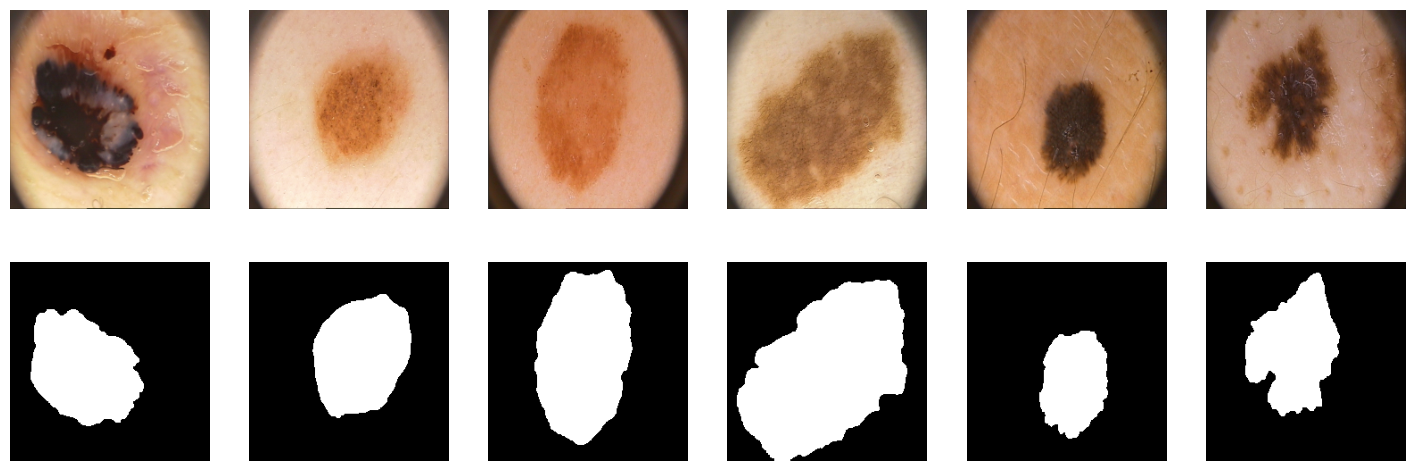

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i], cmap = "gray")
plt.show();

## 1.4. Splitting data into training, validation and testing set

In [8]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [9]:
print(len(tr), len(val), len(ts))

100 50 50


## 1.5. Data augmentation

In [10]:
import random
import cv2
import numpy as np

class VerticalFlip:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            new_img = cv2.flip(img, 0)
            if mask is not None:
                new_mask = cv2.flip(mask, 0)
        return new_img, new_mask


class HorizontalFlip:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            new_img = cv2.flip(img, 1)
            if mask is not None:
                new_mask = cv2.flip(mask, 1)
        return new_img, new_mask


class RandomFlip:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            d = random.randint(-1, 1)
            new_img = cv2.flip(img, d)
            if mask is not None:
                new_mask = cv2.flip(mask, d)
        return new_img, new_mask


class Transpose:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            new_img = img.transpose(1, 0, 2)
            if mask is not None:
                new_mask = mask.transpose(1, 0)
        return new_img, new_mask


class RandomRotate90:
    def __init__(self, prob=0.8):
        self.prob = prob

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            factor = random.randint(0, 4)
            new_img = np.rot90(img, factor)
            if mask is not None:
                new_mask = np.rot90(mask, factor)
        return new_img, new_mask


class Rotate:
    def __init__(self, limit=90, prob=0.8):
        self.prob = prob
        self.limit = limit

    def __call__(self, img, mask=None):
        new_img = img  # Initialize new_img
        new_mask = mask  # Initialize new_mask
        if random.random() < self.prob:
            angle = random.uniform(-self.limit, self.limit)

            height, width = img.shape[0:2]
            mat = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1.0)
            new_img = cv2.warpAffine(img, mat, (height, width),
                                 flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_REFLECT_101)
            if mask is not None:
                new_mask = cv2.warpAffine(mask, mat, (height, width),
                                      flags=cv2.INTER_NEAREST,
                                      borderMode=cv2.BORDER_REFLECT_101)

        return new_img, new_mask
    
class DataAugmentation:
    def __init__(self, transforms=[]):
        self.transforms = transforms

    def __call__(self, img, mask=None):
        augmented_images = []
        augmented_masks = []
        for transform in self.transforms:
            augmented_img, augmented_mask = transform(img, mask)
            augmented_images.append(augmented_img)
            augmented_masks.append(augmented_mask)
        return augmented_images, augmented_masks

2


/tmp/ipykernel_34/2053991358.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 3, i+1)


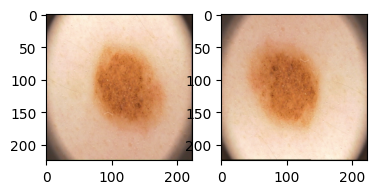

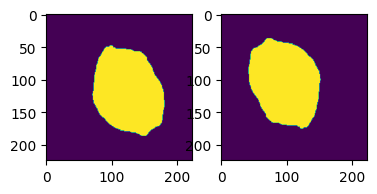

In [11]:
img = X[1]
mask = Y[1]
plt.imshow(img)

# Define your individual augmentation techniques
vertical_flip = VerticalFlip(prob=0.8)
horizontal_flip = HorizontalFlip(prob=0.8)
random_flip = RandomFlip(prob=0.8)
transpose = Transpose(prob=0.8)
random_rotate_90 = RandomRotate90(prob=0.8)
rotate = Rotate(limit=90, prob=0.8)

# Create a DataAugmentation instance with a list of transformations
data_augmentation = DataAugmentation(transforms=[vertical_flip, horizontal_flip])

# Apply data augmentation to an image
augmented_images, augmented_masks = data_augmentation(img, mask)

# Print the number of augmented images
print(len(augmented_images))

# Display each augmented image
for i, augmented_img in enumerate(augmented_images):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_img)
plt.show()

for i, augmented_mask in enumerate(augmented_masks):
    plt.subplot(2, 3, i+1)
    plt.imshow(augmented_mask)
plt.show()

In [12]:
import os

# Define the directories for augmented images and masks
augmented_train_X_dir = "/kaggle/working/augment/trainx/"
augmented_train_Y_dir = "/kaggle/working/augment/trainy/"

# Create directories if they don't exist
os.makedirs(augmented_train_X_dir, exist_ok=True)
os.makedirs(augmented_train_Y_dir, exist_ok=True)

# Loop through each image and mask pair
for i, (img, mask) in enumerate(zip(X[tr], Y[tr])):
    # Apply data augmentation
    augmented_images, augmented_masks = data_augmentation(img, mask)

    # Save augmented images
    for j, aug_img in enumerate(augmented_images):
        img_filename = f"img_{i}_{j}.bmp"
        img_path = os.path.join(augmented_train_X_dir, img_filename)
        cv2.imwrite(img_path, aug_img)

    # Save augmented masks
    for j, aug_mask in enumerate(augmented_masks):
        mask_filename = f"img_{i}_{j}_lesion.bmp"
        mask_path = os.path.join(augmented_train_Y_dir, mask_filename)
        cv2.imwrite(mask_path, aug_mask)
    print("Img path:", img_path, " Mask path:", mask_path)


Img path: /kaggle/working/augment/trainx/img_0_1.bmp  Mask path: /kaggle/working/augment/trainy/img_0_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_1_1.bmp  Mask path: /kaggle/working/augment/trainy/img_1_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_2_1.bmp  Mask path: /kaggle/working/augment/trainy/img_2_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_3_1.bmp  Mask path: /kaggle/working/augment/trainy/img_3_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_4_1.bmp  Mask path: /kaggle/working/augment/trainy/img_4_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_5_1.bmp  Mask path: /kaggle/working/augment/trainy/img_5_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_6_1.bmp  Mask path: /kaggle/working/augment/trainy/img_6_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_7_1.bmp  Mask path: /kaggle/working/augment/trainy/img_7_1_lesion.bmp
Img path: /kaggle/working/augment/trainx/img_8_1.bmp  Mask path: /kaggle/working

In [13]:
images = []
lesions = []
from skimage.io import imread
import os
root_input = "/kaggle/working/augment/trainx"
root_gts = "/kaggle/working/augment/trainy"

for file in os.listdir(root_input):
    images.append(imread(os.path.join(root_input, file)))
    lesions.append(imread(os.path.join(root_gts, file.split('.')[0] + "_lesion.bmp")))

# resize also scales the pixel intensities to (0,1)

from skimage.transform import resize
size = (224, 224)
augmented_X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
augmented_Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

import numpy as np
augmented_X = np.array(augmented_X, np.float32)
augmented_Y = np.array(augmented_Y, np.float32)
print(f'Loaded {len(augmented_X)} images')

# ix = np.random.choice(len(X), len(X), False)
# tr, val, ts = np.split(ix, [100, 150])

# from torch.utils.data import DataLoader
# batch_size = 4
# data_augmented_tr = DataLoader(list(zip(np.rollaxis(augmented_X, 3, 1), augmented_Y[..., np.newaxis])), 
#                      batch_size=batch_size, shuffle=True)

Loaded 200 images


In [14]:
np.rollaxis(X[tr], 3, 1).shape, Y[tr, np.newaxis].shape

((100, 3, 224, 224), (100, 1, 224, 224))

In [15]:
np.rollaxis(augmented_X, 3, 1).shape, augmented_Y[:, np.newaxis].shape

((200, 3, 224, 224), (200, 1, 224, 224))

To use data augmentation, run the commented lines above and comment the three below.
Otherwise, don't change anything.

In [16]:
#X_train = np.vstack((np.rollaxis(X[tr], 3, 1), np.rollaxis(augmented_X, 3, 1)))
#Y_train = np.vstack((Y[tr, np.newaxis], augmented_Y[:, np.newaxis]))
X_train = np.rollaxis(X[tr], 3, 1)
Y_train = Y[tr, np.newaxis]
X_train.shape, Y_train.shape

((100, 3, 224, 224), (100, 1, 224, 224))

## 1.6. Making dataloader

In [17]:
from torch.utils.data import DataLoader
batch_size = 4
data_tr = DataLoader(list(zip(X_train, Y_train)), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

## 1.7. Showing a batch

In [18]:
import torchvision

train_features, train_labels = next(iter(data_tr))

# use torchvision to display a grid of images
def show_batch(images, masks):
    grid_images = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    grid_masks = torchvision.utils.make_grid(masks, nrow=4, normalize=True)

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(grid_images, (1, 2, 0)), )
    plt.show()
    
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(grid_masks, (1, 2, 0)), )
    plt.show()

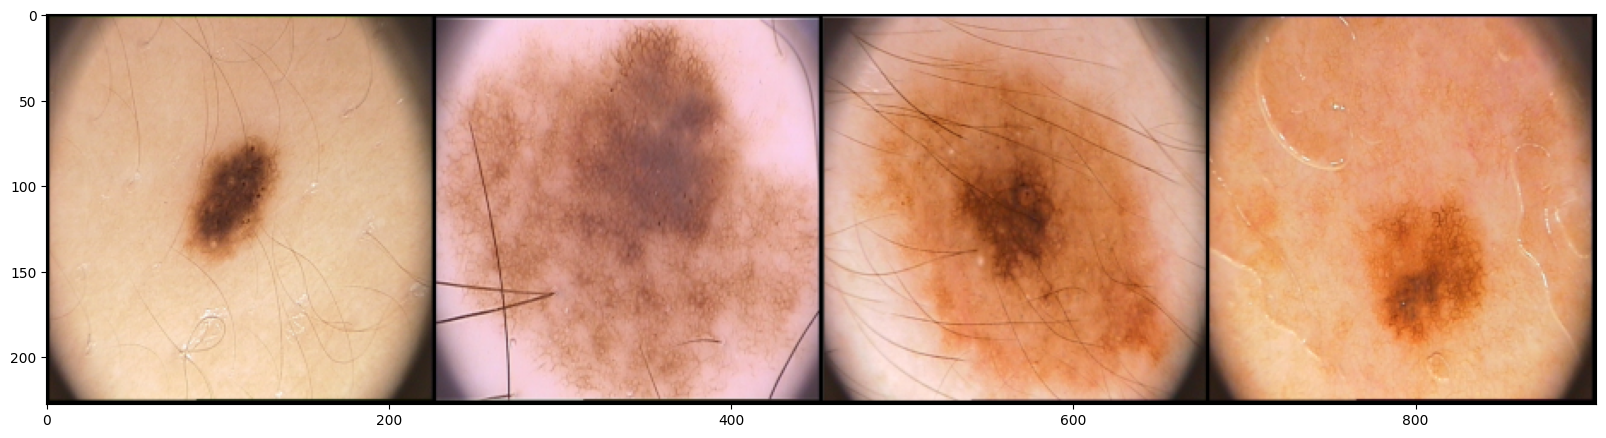

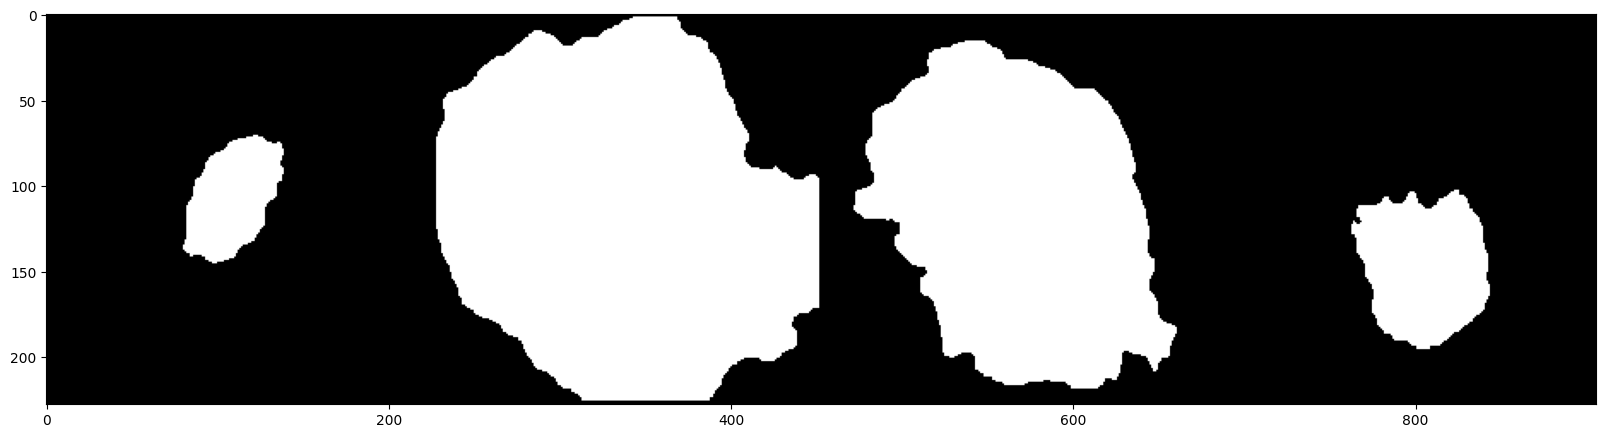

In [19]:
show_batch(train_features, train_labels)

# 2. Models

## 2.1. UNet11 and UNet16 models

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [21]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            vgg - encoder pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.num_classes = num_classes
        
        if pretrained:
            self.encoder = models.vgg11(weights=models.vgg.VGG11_Weights.IMAGENET1K_V1).features
        else:
            self.encoder = models.vgg11().features
        

        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[3],
                                   self.relu)

        self.conv3 = nn.Sequential(
            self.encoder[6],
            self.relu,
            self.encoder[8],
            self.relu,
        )
        self.conv4 = nn.Sequential(
            self.encoder[11],
            self.relu,
            self.encoder[13],
            self.relu,
        )

        self.conv5 = nn.Sequential(
            self.encoder[16],
            self.relu,
            self.encoder[18],
            self.relu,
        )

        self.center = DecoderBlock(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 4, is_deconv=is_deconv)
        self.dec3 = DecoderBlock(256 + num_filters * 4, num_filters * 4 * 2, num_filters * 2, is_deconv=is_deconv)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv=is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)

        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))
        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

In [22]:
class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained: if encoder uses pre-trained weigths from VGG16
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlock(512, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)

        self.dec5 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec4 = DecoderBlock(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        self.dec3 = DecoderBlock(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv=is_deconv)
        self.dec2 = DecoderBlock(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv=is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out


In [23]:
%%capture
!pip install torchsummary

In [26]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
from torchsummary import summary

model11 = UNet11(pretrained=True)
model11.to(device)
summary(model11, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
         MaxPool2d-9         [-1, 64, 112, 112]               0
           Conv2d-10        [-1, 128, 112, 112]          73,856
           Conv2d-11        [-1, 128, 112, 112]          73,856
             ReLU-12        [-1, 128, 112, 112]               0
             ReLU-13        [-1, 128, 112, 112]               0
             ReLU-14        [-1, 128, 1

In [28]:
from torchsummary import summary

model16 = UNet16(pretrained=True)
model16.to(device)
summary(model16, (3, 224, 224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 170MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
              ReLU-3         [-1, 64, 224, 224]               0
              ReLU-4         [-1, 64, 224, 224]               0
              ReLU-5         [-1, 64, 224, 224]               0
              ReLU-6         [-1, 64, 224, 224]               0
              ReLU-7         [-1, 64, 224, 224]               0
              ReLU-8         [-1, 64, 224, 224]               0
            Conv2d-9         [-1, 64, 224, 224]          36,928
           Conv2d-10         [-1, 64, 224, 224]          36,928
             ReLU-11         [-1, 64, 224, 224]               0
             ReLU-12         [-1, 64, 224, 224]               0
             ReLU-13         [-1, 64, 224, 224]               0
             ReLU-14         [-1, 64, 2

## 2.2. Metric:

For quality assessment, we will use the IoU (intersection over union) metric defined as:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [29]:
def iou_pytorch(outputs, labels):
    outputs = outputs.squeeze().byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels =(labels).squeeze().byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou

**Dice coefficient:** Dice cofficient is a popular loss function for object detection and segmentation and is defined as follows: 
$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

You can mention that numerator is the intersection of X and Y and denominator is the union of X and Y

In [30]:
def dice_coefficient(outputs, labels):
    outputs = outputs.squeeze().byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze().byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    total = (outputs + labels).float().sum((1, 2))  # Will be zero if both are 0

    dice = (2. * intersection + SMOOTH) / (total + SMOOTH)  # We smooth our division to avoid 0/0
    return dice

## 2.3. Loss function

To start the training of our model, we will implement two loss functions:


**1. Binary cross-enthropy loss (BCE)**

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is our target and $\hat y$ is an output of the model. $\sigma$ is a logistic function 

**2. BCE with improved numerical stability:**

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [31]:
def BCEWithLogits(y_pred, y_true):
    bcelogits_loss = -y_true * torch.log(torch.sigmoid(y_pred)) - (1 - y_true) * torch.log(torch.sigmoid(1 - y_pred)) 
    # работает хорошо без упрощения
    
    return bcelogits_loss

In [32]:
def BCE_stabilized(y_pred, y_true):
    loss = torch.max(y_pred, torch.zeros_like(y_pred)) - y_pred*y_true + torch.log(1+torch.exp(-torch.abs(y_pred)))
    return loss

# 3. Training and Evaluation

## 3.1. Training

First, we define train function for our training process

In [33]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, sched = None, freq = 1):
    history = []
    for epoch in range(1000000):
        tic = time()
        print(f'Epoch {len(history)} of {epochs}')
        avg_val_loss = 0
        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)
            if math.isnan(loss.mean()):
                continue
            loss.mean().backward()
            opt.step()

            # calculate train loss
            avg_loss += loss.mean() / len(data_tr)
        if avg_loss == 0:
            continue
        toc = time()
        print(f'loss: {avg_loss}')
        
        # calculate val loss and metrics
        model.eval()  # testing mode
        with torch.no_grad():
            for X_val, Y_val in data_val:
                # data to device
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                Y_val_pred = model(X_val)
                loss_val =  loss_fn(Y_val_pred, Y_val)
                avg_val_loss += loss_val.mean() / len(data_val)
            Y_hat = (torch.sigmoid(model(X_val).squeeze()) > 0.5).to(int)
            val_metric = iou_pytorch(Y_hat, Y_val)
            Y_train_hat = (torch.sigmoid(model(X_batch).squeeze()) > 0.5).to(int)
            train_metric = iou_pytorch(Y_train_hat, Y_batch)
        # make a scheduler step
        if sched:
            if epoch % freq == 0:
                sched.step()
                
        # save the training history
        history.append((avg_loss.item(), avg_val_loss.item(), train_metric.mean().item(), val_metric.mean().item()))
        
        # Visualize tools
        clear_output(wait=True)
        Y_hat = Y_hat.detach().cpu().numpy()
        plt.figure(figsize = (4,4))
        for k in range(2):
            plt.subplot(2, 2, k+1)
            plt.imshow(np.rollaxis(X_val[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 2, k+3)
            plt.imshow(Y_hat[k, :, :], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (len(history), epochs, avg_loss))
        plt.show()
        if (len(history) == epochs):
            break
    return history

### Training

clear the GPU memory just in case

In [34]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

214576640

conduct training UNet11 

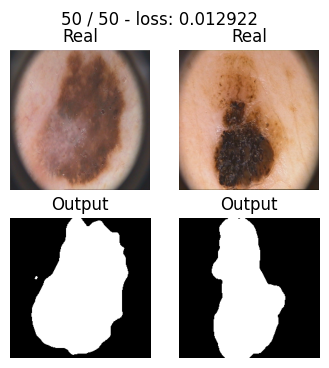

In [35]:
max_epochs = 50
opt = torch.optim.AdamW(model11.parameters(), lr = 4e-5, weight_decay = 1e-4)
history_bce11 = train(model11, opt, BCEWithLogits, max_epochs, data_tr, data_val)

In [36]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

493906944

conduct training UNet16

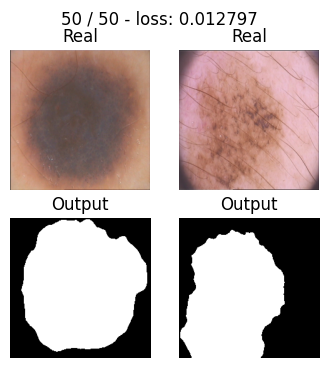

In [37]:
max_epochs = 50
opt = torch.optim.AdamW(model16.parameters(), lr = 4e-5, weight_decay = 1e-4)
history_bce16 = train(model16, opt, BCEWithLogits, max_epochs, data_tr, data_val)

### Visualizing loss and iou metric on training and validation set per epoch

In [38]:
def visualize_and_save(history, savename):
    loss_tr, loss_val, metric_tr, metric_val = zip(*history)
    from seaborn import lineplot
    graphs = plt.figure(figsize = (10, 4))
    ax1 = plt.subplot(1,2,1)
    lineplot({'train': loss_tr, 'val' : loss_val})
    plt.xlabel('Epoch')
    plt.ylabel('Avg Loss')
    ax2 = plt.subplot(1,2,2)
    lineplot({'train':metric_tr, 'val':metric_val})
    plt.xlabel('Epoch')
    plt.ylabel('Avg IoU metric');
    
    # we save the training history for future use
    import pickle
    with open(savename, 'wb') as file:
        pickle.dump(history, file)

UNet11

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

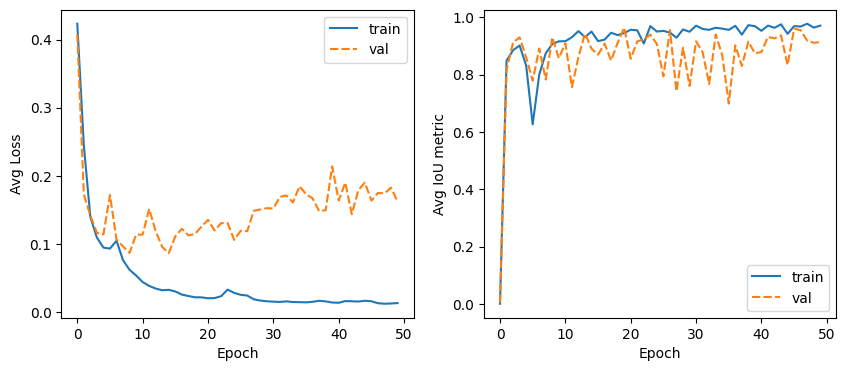

In [39]:
visualize_and_save(history_bce11, 'history_bce')

UNet16

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

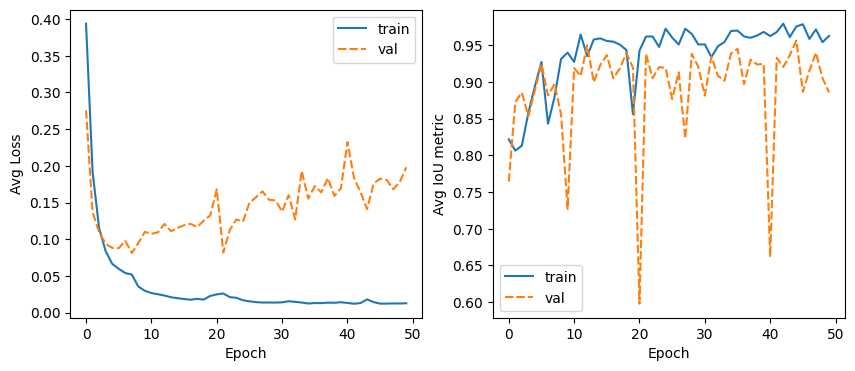

In [40]:
visualize_and_save(history_bce16, 'history_bce')

## 3.2. Prediction and scoring

predict function returns an array of prediction of given data

In [41]:
def predict(model, data):
    test_dataset = np.rollaxis(data, 3, 1)
    model.eval()  # testing mode
    Y_pred = np.zeros(len(data), dtype = 'object')
    idx = 0
    with torch.no_grad():
        X = torch.FloatTensor(test_dataset).to(device)
        preds = (torch.sigmoid(model(X)).squeeze() > 0.5).to(int).cpu().numpy()
        for X in preds:
                Y_pred[idx] = X
                idx+=1
    return Y_pred

score_model function returns metric value of given model and data

In [42]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = (torch.sigmoid(model(X_batch.to(device)).squeeze()) > 0.5).to(int)
            scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

### Okay, let's check how the predict function works:

UNet11

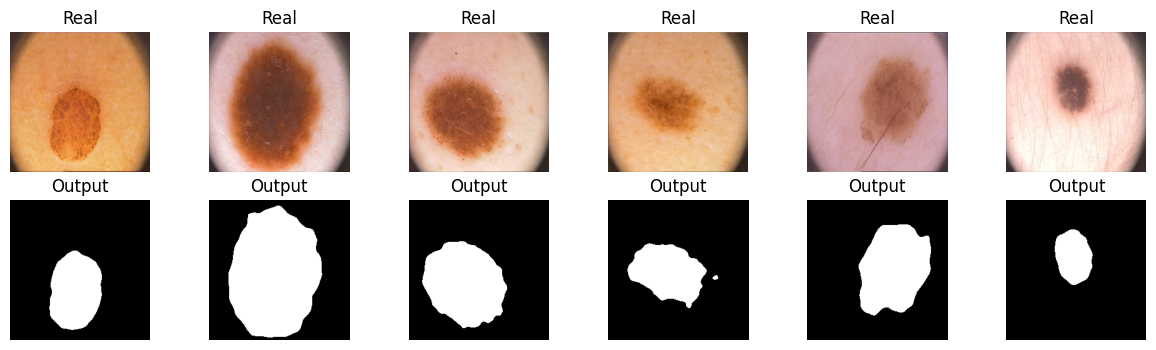

In [43]:
Y_pred = predict(model11, X[ts])

for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(X[ts][k])
    plt.title('Real')
    plt.axis('off')
    
    plt.subplot(2, 6, k+7)
    plt.imshow(Y_pred[k], cmap='gray')
    plt.title('Output')
    plt.axis('off')

UNet16

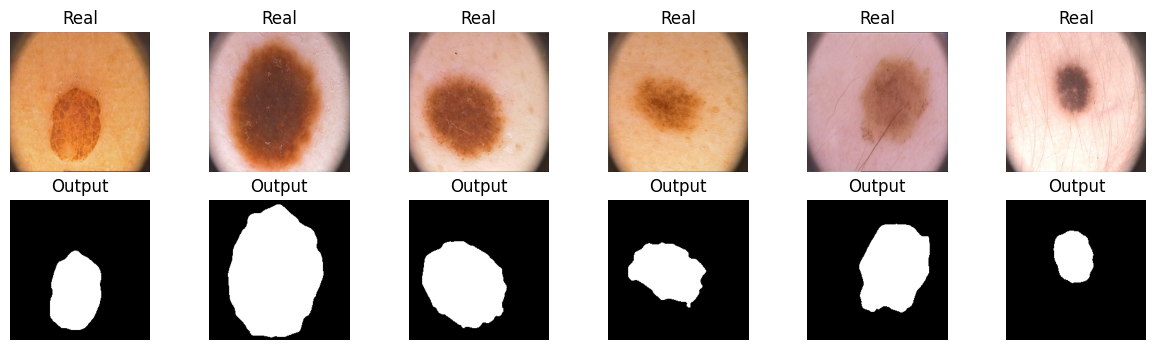

In [44]:
Y_pred = predict(model16, X[ts])

for k in range(6):
    plt.subplot(2, 6, k+1)
    plt.imshow(X[ts][k])
    plt.title('Real')
    plt.axis('off')
    
    plt.subplot(2, 6, k+7)
    plt.imshow(Y_pred[k], cmap='gray')
    plt.title('Output')
    plt.axis('off')

### Calculating and Visulizing iou and meanDice score on UNet11 and UNet16

In [45]:
val_iou_unet11 = round(score_model(model11, iou_pytorch, data_val),3)
val_dice_unet11 = round(score_model(model11, dice_coefficient, data_val),3)
val_iou_unet16 = round(score_model(model16, iou_pytorch, data_val),3)
val_dice_unet16 = round(score_model(model16, dice_coefficient, data_val),3)

In [46]:
test_iou_unet11 = round(score_model(model11, iou_pytorch, data_ts),3)
test_dice_unet11 = round(score_model(model11, dice_coefficient, data_ts),3)
test_iou_unet16 = round(score_model(model16, iou_pytorch, data_ts),3)
test_dice_unet16 = round(score_model(model16, dice_coefficient, data_ts),3)

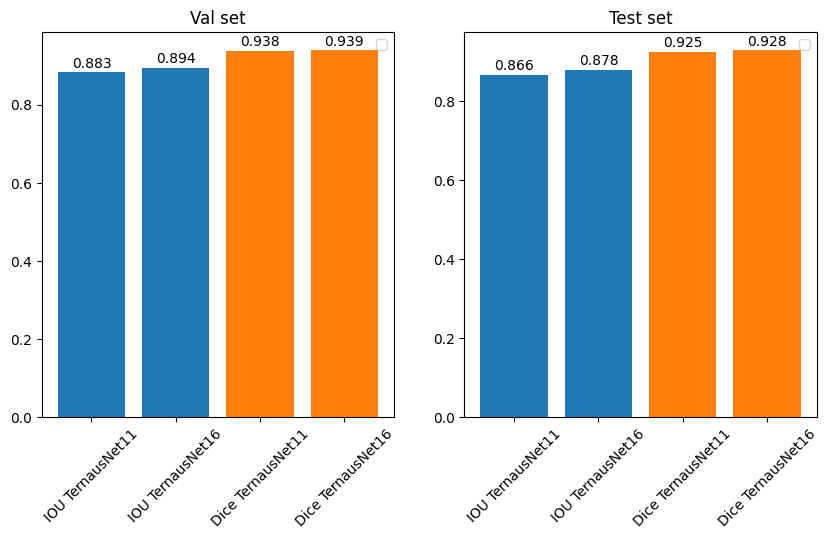

In [47]:
val = [val_iou_unet11, val_iou_unet16, val_dice_unet11, val_dice_unet16]
test = [test_iou_unet11, test_iou_unet16, test_dice_unet11, test_dice_unet16]
categories = ['IOU TernausNet11', 'IOU TernausNet16', 'Dice TernausNet11', 'Dice TernausNet16']
colors = ['C0', 'C0', 'C1', 'C1']

fig = plt.figure(figsize=(10, 5))

fig.add_subplot(1, 2, 1)
bars = plt.bar(categories, val, color=colors)
# Add the exact values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, yval, ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title('Val set')
plt.legend()

fig.add_subplot(1, 2, 2)
bars = plt.bar(categories, test, color=colors)
# Add the exact values on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, yval, ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title('Test set')
plt.legend()

plt.show()